In [4]:
from comm_utils import load_server_data, load_client_data, process_rounds_time, filter_round_time, network_log_to_csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from types import SimpleNamespace
from box import Box
import json

In [9]:
exp_path = "/home/tunguyen/energyfl/outputcifar10/10clients/comm/fedadagrad/labelskew/2024-04-30_00-20-56"

In [10]:
def read_server_clients_data(exp_path):
    host_ids = [int(name.split('_')[-1]) for name in os.listdir(exp_path) if 'client' in name]
    outputs = Box()
    for i in host_ids:
        #client_path = os.path.join(exp_path, f'client_host_{i}')
        client_processes, client_fittimes, client_energy, client_network, client_df = load_client_data(exp_path, i)
        outputs[f'client_{i}'] = Box(processes=client_processes, energy=client_energy, time=client_fittimes, network=client_network, log=client_df)
    server_path = os.path.join(exp_path, 'server')
    server_processes, server_energy, server_time, server_network, server_df = load_server_data(exp_path)
    outputs['server'] = Box(processes=server_processes, energy=server_energy, time=server_time, network=server_network, df=server_df)
    return outputs

In [11]:
files = read_server_clients_data(exp_path)

In [22]:
files.server.time

,round,timestamp,call,status
0,1,2024-04-30 00:21:53.299218,fit,start fit call
1,1,2024-04-30 00:22:33.173872,fit,res fit received
2,1,2024-04-30 00:22:33.174259,fit,res fit aggregated
3,1,2024-04-30 00:22:33.174489,evaluate,central evaluate call
4,1,2024-04-30 00:22:38.663403,evaluate,central evaluated
...,...,...,...,...
895,100,2024-04-30 01:29:08.643763,evaluate,central evaluated
896,100,2024-04-30 01:29:08.644715,evaluate,central evaluate end
897,100,2024-04-30 01:29:08.645020,evaluate,distributed evaluate call
898,100,2024-04-30 01:29:13.522433,evaluate,distributed evaluated


In [27]:
server_round_time = process_rounds_time(files.server.time, mode='round')
client_0_round_time = filter_round_time(server_round_time, files.client_0.network)
client_0_round_time

,timestamp,process,send,receive,round,round time
9,2024-04-30 00:21:53.659849,python3/200410/0,0.550586,0.844141,1,50.282862
10,2024-04-30 00:21:54.635290,python3/200410/0,0.550586,0.844141,1,50.282862
11,2024-04-30 00:21:55.024320,python3/200410/0,6.553710,2390.620000,1,50.282862
12,2024-04-30 00:21:56.652403,python3/200410/0,22.490600,8765.140000,1,50.282862
13,2024-04-30 00:21:57.656514,python3/200410/0,22.490600,8765.140000,1,50.282862
...,...,...,...,...,...,...
4041,2024-04-30 01:29:08.695958,python3/200410/0,8760.520000,68.776800,100,40.143852
4042,2024-04-30 01:29:09.320238,python3/200410/0,0.253320,23.422700,100,40.143852
4043,2024-04-30 01:29:10.025768,python3/200410/0,9.315430,3639.070000,100,40.143852
4044,2024-04-30 01:29:11.041864,python3/200410/0,21.007200,8138.950000,100,40.143852


In [32]:
def process_host_round_time(files_holder, host:str):
    server_round_time = process_rounds_time(files_holder.server.time, mode='round')
    host_round_time = filter_round_time(server_round_time, files_holder[host].network)
    send, receives = [], []
    rounds = host_round_time['round'].unique()
    for r in rounds:
        send_r = host_round_time[host_round_time['round'] == r]['send'].sum()/1024
        receive_r = host_round_time[host_round_time['round'] == r]['receive'].sum()/1024
    return host_round_time

ok = process_host_round_time(files, 'client_0')
ok

(                      timestamp           process         send      receive  \
 9    2024-04-30 00:21:53.659849  python3/200410/0     0.550586     0.844141   
 10   2024-04-30 00:21:54.635290  python3/200410/0     0.550586     0.844141   
 11   2024-04-30 00:21:55.024320  python3/200410/0     6.553710  2390.620000   
 12   2024-04-30 00:21:56.652403  python3/200410/0    22.490600  8765.140000   
 13   2024-04-30 00:21:57.656514  python3/200410/0    22.490600  8765.140000   
 ...                         ...               ...          ...          ...   
 4041 2024-04-30 01:29:08.695958  python3/200410/0  8760.520000    68.776800   
 4042 2024-04-30 01:29:09.320238  python3/200410/0     0.253320    23.422700   
 4043 2024-04-30 01:29:10.025768  python3/200410/0     9.315430  3639.070000   
 4044 2024-04-30 01:29:11.041864  python3/200410/0    21.007200  8138.950000   
 4045 2024-04-30 01:29:12.748159  python3/200410/0    22.767200  8765.300000   
 
       round  round time  
 9         

In [14]:
def plot_multples_clients(file_holder):
    server_time = file_holder.server.time
    clients = sorted([client for client in file_holder.keys() if 'client' in client])
    server_round_time = process_rounds_time(server_time, mode='round')
    server_filter = filter_round_time(server_round_time, file_holder.server.network)
    
    fig, axs = plt.subplots(2, 1, figsize=(20, 5))
    rounds = server_filter['round'].unique()
    for client in clients:
        client_network = file_holder[client].network
        client_filtered = filter_round_time(server_round_time, client_network)
        sends, receives = [], []
        for r in rounds:
            send_sum = client_filtered[client_filtered['round'] == r].send.sum()/1024
            recv_sum = client_filtered[client_filtered['round'] == r].receive.sum()/1024
            sends.append(send_sum)
            receives.append(recv_sum)
        axs[0].plot(rounds, sends, label=f"{client}")#,marker='^', markevery=1, linewidth=2)
        axs[1].plot(rounds, receives, label=f"{client}")#,marker='^', markevery=1, linewidth=2)
    
    axs[0].set_title("Send")
    axs[1].set_title("Receive")
    axs[0].set_ylabel("MB")
    axs[1].set_ylabel("MB")
    axs[1].set_xlabel("Round")
    legend = fig.legend(clients, 
                        loc="upper center", 
                        bbox_to_anchor=(0.5, 1.0), 
                        ncol=len(clients),
                        fontsize=12,)
    
    fig_server, axs_server = plt.subplots(2, 1, figsize=(20, 5))
    server_sends, server_receives = [], []
    for r in rounds:
        send_sum = server_filter[server_filter['round'] == r].send.sum()/1024
        recv_sum = server_filter[server_filter['round'] == r].receive.sum()/1024
        server_sends.append(send_sum)
        server_receives.append(recv_sum)
    axs_server[0].plot(rounds, server_sends, label="Server")#,marker='^', markevery=1, linewidth=2)
    axs_server[1].plot(rounds, server_receives, label="Server")#,marker='^', markevery=1, linewidth=2)
    axs_server[0].set_title("Send")
    axs_server[1].set_title("Receive")
    axs_server[0].set_ylabel("MB")
    axs_server[1].set_ylabel("MB")
    axs_server[0].set_xlabel("Round")
    legend = fig.legend(["Server"], 
                        loc="upper center", 
                        bbox_to_anchor=(0.5, 1.0), 
                        ncol=1,
                        fontsize=12,)

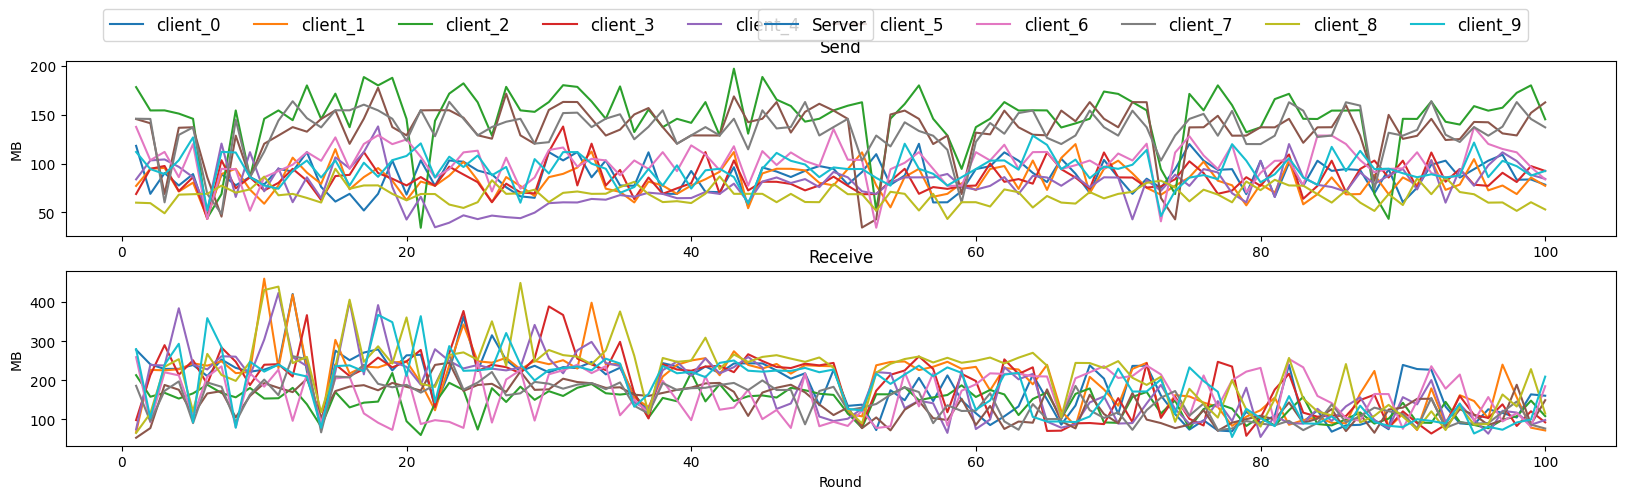

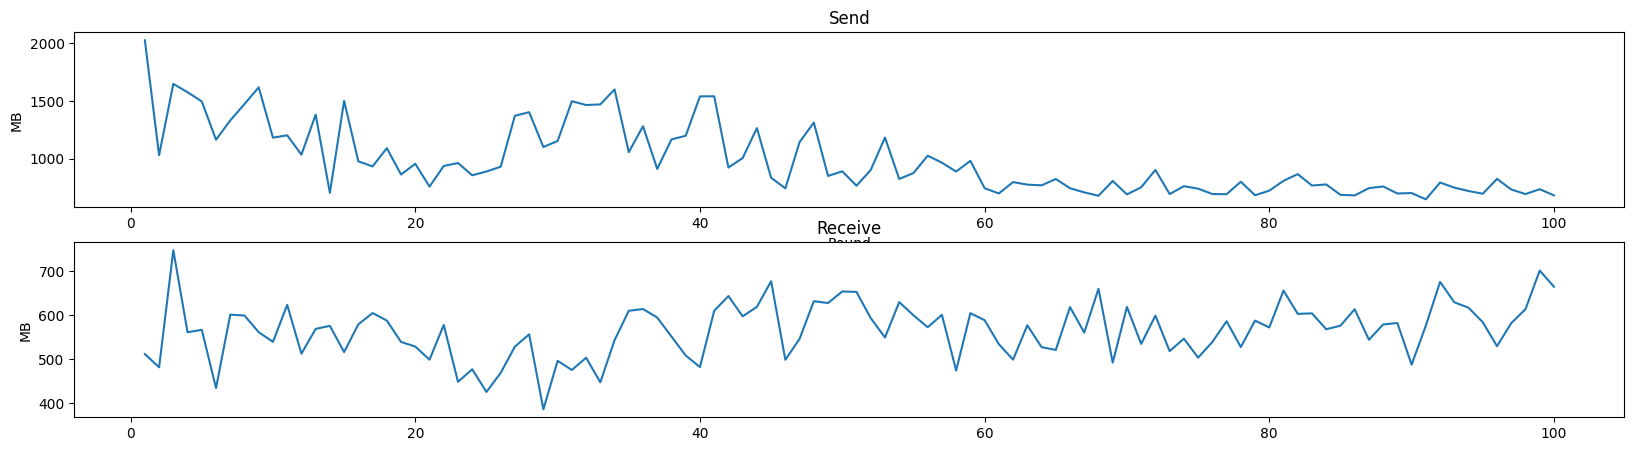

In [15]:
plot_multples_clients(files)